# Imports


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import time
from matplotlib import pyplot as plt


# Actor

In [2]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """
        sets the weights of the network to a uniforma distribution betweenn -0.003 and 0.003
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

# Critic

In [3]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """
        sets the weights of the network to a uniforma distribution betweenn -0.003 and 0.003
        """
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Memory

In [4]:
class ReplayBuffer():
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): Random seed
        """
        random.seed(seed)
        np.random.seed(seed)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Noise

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        random.seed(seed)
        np.random.seed(seed)
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        #self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

# Agent

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MultiAgent():
    """Agent that contains the two DDPG agents and the shared replay buffer."""

    def __init__(self,action_size=2,state_size=24,seed=0,n_agents=2,buffer_size=int(1e6),batch_size=64,update_every=2,noise_start=1.0,noise_decay=0.1,exploration=50000):

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.n_agents = n_agents
        self.noise_weight = noise_start
        self.noise_decay = noise_decay
        self.time_step = 0
        self.noise_on = True
        self.exploration = exploration
        self.action_size = action_size

        #create agents each with an actor and a shared critic
        self.critic_local = Critic(state_size,action_size, seed).to(device)
        self.critic_target = Critic(state_size,action_size, seed).to(device)
        
        self.agents = [Agent(self.critic_local,self.critic_target) for i in range(n_agents)]

        # create shared replay buffer
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

    def step(self, states, actions, rewards, next_states, dones):
        """
        take in the states, actions, rewards, next_states, dones for both agents and take a step for
        each agent.save experience and learn.
        """
        self.memory.add(states, actions, rewards, next_states, dones)
        
        if self.time_step > self.exploration:
            self.noise_on = False

        self.time_step = self.time_step + 1
        if self.time_step % self.update_every == 0:
            if len(self.memory) > self.batch_size:
                self.learn()

    def act(self, states, add_noise=True):
        """
        take in the current states for each agent
        returns the actions for each agent
        """
        
        agent_actions = np.zeros((self.n_agents,self.action_size),dtype=float)
        for i, agent in enumerate(self.agents):
            agent_actions[i] = agent.act(states[i], add_noise=self.noise_on)
            self.noise_weight *= self.noise_decay
        return agent_actions

    def learn(self):
        for agent in self.agents:
            experiences = self.memory.sample()
            agent.learn(experiences)
            
    def save_agents(self):
        for agent in self.agents:
            torch.save(agent.actor_local.state_dict(),  'models/avg_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/avg_critic.pth')

In [7]:
LRA = 0.0001
LRC = 0.0001
WEIGHT_DECAY = 0
BUFFER_SIZE = 10000000
BATCH_SIZE=512
UPDATE_SIZE=10
GAMMA=0.99
TAU=0.001
SEED=2

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self,
                 critic_local,
                 critic_target,
                 action_size=2,
                 seed=2,
                 tau=1e-3,
                 lr_actor=1e-4,
                 lr_critic=1e-4,
                 weight_decay=0.0,
                 gamma=0.99):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network (w/ Target Network)
#         self.critic_local = critic_local
#         self.critic_target = critic_target
        self.critic_local = Critic(state_size,action_size, seed).to(device)
        self.critic_target = Critic(state_size,action_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic, weight_decay=weight_decay)
        
        # Noise process
        self.noise = OUNoise(action_size, self.seed)
            
    def act(self, state, add_noise=True):
        """
        Returns actions for given state for this agent
        """
    
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)                    

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



# Training

In [8]:

env = UnityEnvironment(file_name="Tennis.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [9]:
#Constants
LRA = 0.0001
LRC = 0.0001
WEIGHT_DECAY = 0
BUFFER_SIZE = 10000000
BATCH_SIZE=64
UPDATE_SIZE=10
GAMMA=0.97
TAU=1e-3
ACTION_SIZE=2
SEED=0
NUM_AGENTS=2
UPDATE_FREQUENCY=2,
NOISE_START=1.0,
NOISE_DECAY=1.0,
EXPLORATION=50000

scores_avg = []
agent1_scores = []
agent2_scores = []

def train(agent, n_episodes=10000, max_t=1000):
    scores = []
    scores_deque = deque(maxlen=100)
    best_avg = 0
    
    start_time = time.time()     # Start time
    solved = False

    for i_episode in range(1, n_episodes+1):
        scores = []
        env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
        #for agent in agents:
        #    agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        score1 = 0
        score2 = 0
        # loop over steps
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
                
            states = next_states
            score1 += rewards[0]
            score2 += rewards[1]
            scores.append(rewards)
            if any(dones):
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = max(score1,score2)
        agent1_scores.append(score1)
        agent2_scores.append(score2)
        scores.append(episode_reward)             # save most recent score to overall score array
        scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
        scores_avg.append(np.mean(scores_deque))      # save average of last 100 scores to average score array
    
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, scores_avg[-1]),end="")
        
        # log average score every 200 episodes
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, scores_avg[-1]))
        
        if np.mean(scores_deque)>=2.4 and solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_agents()
            solved=True
            
        # break and report success if environment is solved
        if np.mean(scores_deque)>=2.4:
            print('\n 2.4 Avg in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_agents()
            break
        elif np.mean(scores_deque) > best_avg+0.1 :
            best_avg = np.mean(scores_deque)
            agent.save_agents()
    
    time_elapsed = time.time() - start_time
    print("\nTime Elapse: {:.3f}".format(time_elapsed))
    
    return [scores, agent1_scores, agent2_scores]

In [10]:
agent = MultiAgent()
scores = train(agent, 8000, 1000)

Episode 200	Average Score: 0.017
Episode 400	Average Score: 0.033
Episode 600	Average Score: 0.041
Episode 800	Average Score: 0.057
Episode 1000	Average Score: 0.070
Episode 1200	Average Score: 1.520
Episode 1265	Average Score: 2.175

KeyboardInterrupt: 

# Results

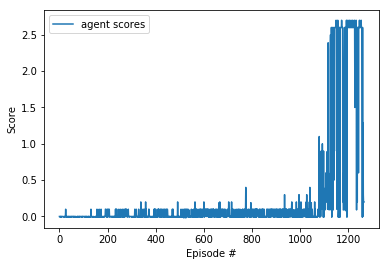

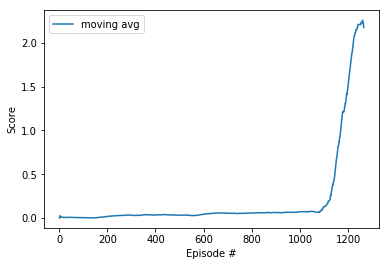

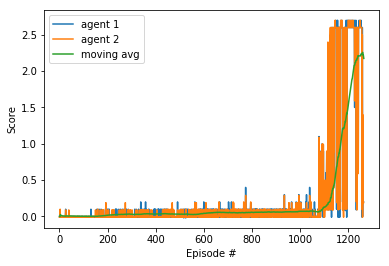

In [16]:
training_scores = scores_avg[0]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(agent1_scores)), agent1_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['agent scores'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['moving avg'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(agent1_scores)), agent1_scores)
plt.plot(np.arange(len(agent2_scores)), agent2_scores)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['agent 1', 'agent 2', 'moving avg'], loc='upper left')
plt.show()

In [ ]:
env.close()